##Imports

In [ ]:
from google.colab import files
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam

##Loading Data

In [ ]:
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samekrangarajan1","key":"df74bf68a743502a9e88df880485221c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle
!kaggle datasets download -d mohitsingh1804/plantvillage
!unzip -q plantvillage.zip -d plantvillage

Dataset URL: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage
License(s): GPL-2.0


In [ ]:
root_path = "/content/plantvillage/PlantVillage/train"
print(os.listdir(root_path))

['Tomato___Early_blight', 'Corn_(maize)___healthy', 'Squash___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Peach___healthy', 'Grape___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Tomato___Target_Spot', 'Tomato___Leaf_Mold', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Soybean___healthy', 'Apple___Apple_scab', 'Blueberry___healthy', 'Pepper,_bell___Bacterial_spot', 'Tomato___healthy', 'Corn_(maize)___Common_rust_', 'Apple___healthy', 'Pepper,_bell___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Potato___Early_blight', 'Potato___healthy', 'Apple___Black_rot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Grape___Esca_(Black_Measles)', 'Tomato___Bacterial_spot', 'Tomato___Septoria_leaf_spot', 'Grape___Black_rot', 'Apple___Cedar_apple_rust', 'Tomato___Late_blight', 'Raspberry___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Grape___Leaf_blight_(Isa

In [ ]:
train_dir = "/content/plantvillage/PlantVillage/train"
val_dir = "/content/plantvillage/PlantVillage/val"
filtered_train_dir = "/content/filtered_plantvillage/train"
filtered_val_dir = "/content/filtered_plantvillage/val"

wanted_classes = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight',
    'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Peach___Bacterial_spot', 'Peach___healthy',
    'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
    'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight',
    'Strawberry___healthy', 'Strawberry___Leaf_scorch',
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight',
    'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

def copy_filtered_classes(src_dir, dst_dir, class_list):
    os.makedirs(dst_dir, exist_ok=True)
    for class_name in class_list:
        src_path = os.path.join(src_dir, class_name)
        dst_path = os.path.join(dst_dir, class_name)
        if os.path.exists(src_path):
            shutil.copytree(src_path, dst_path)
        else:
            print(f"[Warning] Not found: {src_path}")

copy_filtered_classes(train_dir, filtered_train_dir, wanted_classes)
copy_filtered_classes(val_dir, filtered_val_dir, wanted_classes)

In [ ]:
val_dir = "/content/filtered_plantvillage/val"
test_dir = "/content/filtered_plantvillage/test"

# Create the test set by moving 20% from val to test
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(val_dir):
    class_path = os.path.join(val_dir, class_name)
    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    test_files, keep_val_files = train_test_split(files, test_size=0.8, random_state=42)

    # Make class dirs
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    for f in test_files:
        shutil.move(os.path.join(class_path, f), os.path.join(test_dir, class_name))

##Augementation

In [ ]:
img_height, img_width = 224, 224
batch_size = 32

# Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=25,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# No augmentation for validation, just rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

train_loader = train_datagen.flow_from_directory(
    "/content/filtered_plantvillage/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_loader = val_datagen.flow_from_directory(
    "/content/filtered_plantvillage/val",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 32000 images belonging to 33 classes.
Found 6410 images belonging to 33 classes.


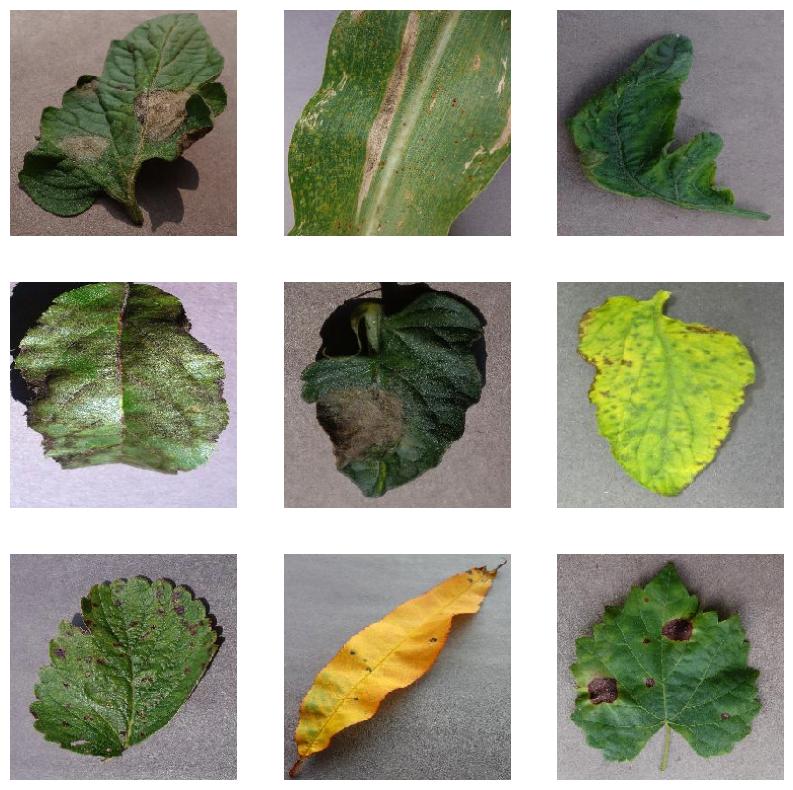

In [ ]:
# Get a batch
images, labels = next(train_loader)

# Show 9 examples
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()

##Model training

In [ ]:
# Load base DenseNet121
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base layers (initial training)
base_model.trainable = False

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(train_loader.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=10
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 191s 161ms/step - accuracy: 0.5719 - loss: 1.5958 - val_accuracy: 0.8972 - val_loss: 0.3932
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 135s 134ms/step - accuracy: 0.8584 - loss: 0.4657 - val_accuracy: 0.9187 - val_loss: 0.2909
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 130s 130ms/step - accuracy: 0.8778 - loss: 0.3927 - val_accuracy: 0.9248 - val_loss: 0.2543
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 132s 132ms/step - accuracy: 0.8818 - loss: 0.3604 - val_accuracy: 0.9300 - val_loss: 0.2344
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - accuracy: 0.8915 - loss: 0.3274 - val_accuracy: 0.9295 - val_loss: 0.2227
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 136s 136ms/step - accuracy: 0.8935 - loss: 0.3168 - val_accuracy: 0.9306 - val_loss: 0.2234
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 132s 132ms/step - accuracy: 0.8959 - loss: 0.3130 - val_accuracy: 0.9349 - val_loss: 0.2004
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 134s 134ms/step - ac

##Testing + Evaluation

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_loader = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_loader)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


